### Run in collab
<a href="https://colab.research.google.com/github/racousin/data_science_practice/blob/master/website/public/modules/module13/exercise/module13_exercise2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install swig==4.2.1
!pip install gymnasium==0.29.1

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

# module13_exercise2 : ML - Arena <a href="https://ml-arena.com/viewcompetition/5" target="_blank"> FrozenLake Competition</a>

### Objective
Get at list an agent running on ML-Arena <a href="https://ml-arena.com/viewcompetition/5" target="_blank"> FrozenLake Competition</a> with mean reward upper than 0.35 (ie 35%)


You should submit an agent file named `agent.py` with a class `Agent` that includes at least the following attributes:

### Description

The game starts with the player at location [0,0] of the frozen lake grid world with the goal located at far extent of the world [7,7].

Holes in the ice are distributed in set locations.

The player makes moves until they reach the goal or fall in a hole.

Each run will consist of 10 attempts to cross the ice. The reward will be the total amount accumulated during those trips. For example, if your agent reaches the goal 3 times out of 10, its reward will be 3.

The environment is based on :

In [3]:
env = gym.make('FrozenLake-v1', map_name="8x8")

In [5]:
# Training
def execute_training_loop(env, learner, n_episodes, training_mode=True, max_len=200, random_seed=123):

    episode_returns = np.zeros(n_episodes)
    rng = np.random.default_rng(random_seed)

    for ep in range(n_episodes):
        obs, _ = env.reset(seed=random_seed + ep)
        done, truncated = False, False
        cumulative = 0.0
        step = 0

        while not (done or truncated) and step < max_len:
            # sélection d'action via la stratégie du learner
            act = learner.select_action(obs)
            next_obs, rew, done, truncated, _ = env.step(act)

            if training_mode:
                learner.update(obs, act, rew, next_obs, done or truncated)

            cumulative += rew
            obs = next_obs
            step += 1

        episode_returns[ep] = cumulative
    return episode_returns

In [ ]:
# Agent epsilon-greedy decay

def get_epsilon_greedy_decay_action(Q_s, episode_idx,
                                    epsilon_start=1.0, epsilon_end=0.05, decay_rate=0.995):
    eps_t = max(epsilon_end, epsilon_start * (decay_rate ** episode_idx))
    if np.random.rand() < eps_t:
        return np.random.randint(len(Q_s))
    return int(np.argmax(Q_s))

class Agent_EpsilonDecay:
    def __init__(self, env,
                 gamma=0.99, alpha=0.05,
                 epsilon_start=1.0, epsilon_end=0.05, decay_rate=0.995):
        self.env = env
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.decay_rate = decay_rate
        self.q = np.ones((env.observation_space.n, env.action_space.n)) * 0.5
        self._episode_idx = 0  # incrémenté à la fin de chaque épisode

    def select_action(self, state):
        return get_epsilon_greedy_decay_action(
            self.q[state],
            episode_idx=self._episode_idx,
            epsilon_start=self.epsilon_start,
            epsilon_end=self.epsilon_end,
            decay_rate=self.decay_rate,
        )

    def update(self, s, a, r, s_next, done):
        target = r + (0.0 if done else self.gamma * np.max(self.q[s_next]))
        td = target - self.q[s, a]
        self.q[s, a] += self.alpha * td
        if done:
            self._episode_idx += 1

    # alias si tu réutilises l’ancien nom ailleurs
    act   = select_action
    train = update

In [ ]:
# Run rapide (un seul set d'hyperparams) + plot

n_episodes = 5000
agent_eps_decay = Agent_EpsilonDecay(
    env, gamma=0.99, alpha=0.05,
    epsilon_start=1.0, epsilon_end=0.05, decay_rate=0.995
)
returns_eps_decay = execute_training_loop(env, agent_eps_decay, n_episodes)

window_size = 100
kernel = np.ones(window_size) / window_size
ma_eps_decay = np.convolve(returns_eps_decay, kernel, mode='valid')

plt.figure(figsize=(6, 3.2))
plt.plot(returns_eps_decay, 'o', alpha=0.3, label='Rewards bruts')
plt.plot(range(window_size - 1, len(returns_eps_decay)), ma_eps_decay,
         color='orange', label=f'Moyenne mobile ({window_size})')
plt.title('Agent ε-greedy décroissant')
plt.xlabel('Épisode'); plt.ylabel('Cumulative Reward'); plt.legend()
plt.tight_layout(); plt.show()

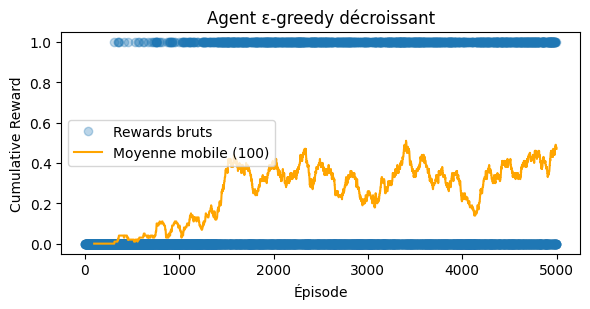

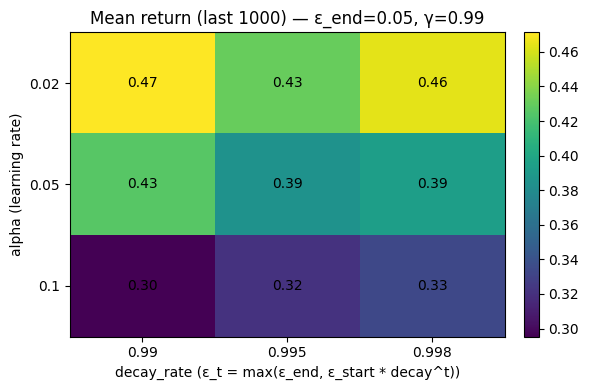

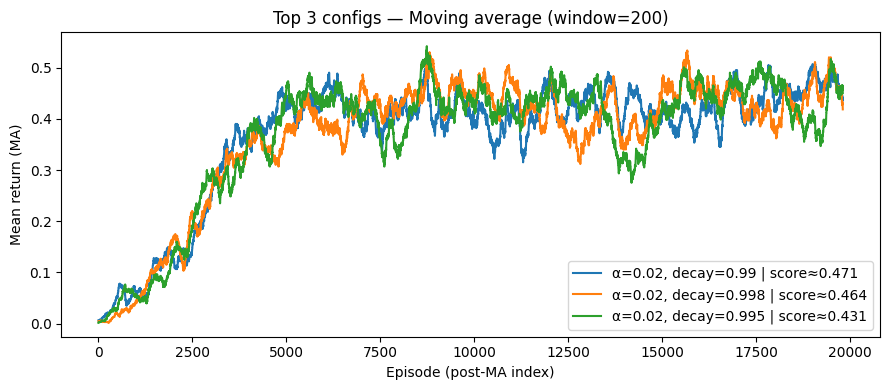

Best config:
  alpha       = 0.02
  decay_rate  = 0.99
  epsilon_end = 0.05
  gamma       = 0.99
  score       = 0.4713 (mean of last 1000, avg over seeds=(0, 1, 2))


In [ ]:
# Mini-grid des hyperparamètres ε-decay + heatmap + top-3
def moving_avg(x, k=100):
    if len(x) < k: 
        return np.asarray(x)
    w = np.ones(k) / k
    return np.convolve(x, w, mode='valid')

def eval_config(env, alpha, decay_rate, epsilon_start=1.0, epsilon_end=0.05,
                gamma=0.99, n_episodes=20000, seeds=(0,1,2),
                last_k_for_score=1000, ma_window=200):
    curves = []
    scores = []
    for sd in seeds:
        agent = Agent_EpsilonDecay(
            env, gamma=gamma, alpha=alpha,
            epsilon_start=epsilon_start, epsilon_end=epsilon_end, decay_rate=decay_rate
        )
        returns = execute_training_loop(env, agent, n_episodes, random_seed=sd)
        curves.append(moving_avg(returns, ma_window))
        tail = returns[-last_k_for_score:] if len(returns) >= last_k_for_score else returns
        scores.append(np.mean(tail))
    # aligner les courbes MA
    L = min(len(c) for c in curves)
    curves = [c[-L:] for c in curves]
    curve_ma = np.mean(np.stack(curves, axis=0), axis=0)
    return {
        "score": float(np.mean(scores)),
        "curve_ma": curve_ma,
        "alpha": alpha,
        "decay_rate": decay_rate,
        "epsilon_end": epsilon_end,
        "gamma": gamma
    }

# Grille
n_episodes_grid = 20000
ma_window  = 200
last_k     = 1000
seeds      = (0,1,2)

alphas       = [0.02, 0.05, 0.10]
decay_rates  = [0.990, 0.995, 0.998]
epsilon_end  = 0.05
gamma        = 0.99

results = []
for a, d in product(alphas, decay_rates):
    out = eval_config(env, alpha=a, decay_rate=d, epsilon_end=epsilon_end,
                      gamma=gamma, n_episodes=n_episodes_grid, seeds=seeds,
                      last_k_for_score=last_k, ma_window=ma_window)
    results.append(out)

# Heatmap
score_mat = np.zeros((len(alphas), len(decay_rates)))
for i, a in enumerate(alphas):
    for j, d in enumerate(decay_rates):
        score_mat[i, j] = next(r["score"] for r in results if r["alpha"]==a and r["decay_rate"]==d)

plt.figure(figsize=(6, 4))
im = plt.imshow(score_mat, aspect='auto')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(decay_rates)), [str(d) for d in decay_rates])
plt.yticks(range(len(alphas)), [str(a) for a in alphas])
plt.xlabel("decay_rate (ε_t = max(ε_end, ε_start * decay^t))")
plt.ylabel("alpha (learning rate)")
plt.title(f"Mean return (last {last_k}) — ε_end={epsilon_end}, γ={gamma}")
for i in range(len(alphas)):
    for j in range(len(decay_rates)):
        plt.text(j, i, f"{score_mat[i,j]:.2f}", ha='center', va='center')
plt.tight_layout(); plt.show()

# Top-3 courbes
top_k = 3
results_sorted = sorted(results, key=lambda r: r["score"], reverse=True)[:top_k]

plt.figure(figsize=(9, 4))
for r in results_sorted:
    curve = r["curve_ma"]
    x = np.arange(len(curve))
    lbl = f"α={r['alpha']}, decay={r['decay_rate']} | score≈{r['score']:.3f}"
    plt.plot(x, curve, label=lbl)
plt.title(f"Top {top_k} configs — Moving average (window={ma_window})")
plt.xlabel("Episode (post-MA index)"); plt.ylabel("Mean return (MA)")
plt.legend(); plt.tight_layout(); plt.show()

best = results_sorted[0]
print("Best config:")
print(f"  alpha       = {best['alpha']}")
print(f"  decay_rate  = {best['decay_rate']}")
print(f"  epsilon_end = {best['epsilon_end']}")
print(f"  gamma       = {best['gamma']}")
print(f"  score       = {best['score']:.4f} (mean of last {last_k}, avg over seeds={seeds})")

In [ ]:
agent_eps_decay = Agent_EpsilonDecay(
    env,
    gamma=0.99,
    alpha=0.02,
    epsilon_start=1.0,
    epsilon_end=0.05,
    decay_rate=0.99
)
returns_eps_decay = execute_training_loop(env, agent_eps_decay, n_episodes=20000)

In [14]:
import numpy as np
np.set_printoptions(suppress=True, precision=6)  # pour un affichage propre
print(agent_eps_decay.q.tolist())

[[0.29420995385560217, 0.2950634022720467, 0.294264371748934, 0.292005118609326], [0.30260766833240094, 0.30252921011496864, 0.3063348442238046, 0.30303728824092435], [0.30413644321670846, 0.31444525168285875, 0.32121601400641536, 0.3151170093074783], [0.32922190454203654, 0.3299628666925131, 0.33870964281300375, 0.32435021886832976], [0.35067493294855384, 0.35103205231633, 0.36187477989983363, 0.3459180657178977], [0.36853061166782275, 0.3692578415676267, 0.38701590644541994, 0.3685439191670447], [0.3895959438840707, 0.389621196584198, 0.4054396444753669, 0.3880749988106463], [0.40733073465670694, 0.39230821043866465, 0.3900784436458687, 0.3863725607179519], [0.29101726983769477, 0.2907994925705392, 0.2910708139035046, 0.29351206752249603], [0.29407473720389976, 0.29458600393201834, 0.2949264719933318, 0.3004210919639085], [0.2961404397875992, 0.2940007985759691, 0.30196432884961155, 0.3133460907802189], [0.2342952456648879, 0.225624879435896, 0.20496204754952885, 0.33121734757643734]

### Before submit
Test that your agent has the right attributes

In [ ]:
#  For submission 

import random

class Agent:
    """
    Agent FrozenLake-v1 (8x8, slippery)
    Politique fixe issue d'un entraînement Q-learning (α=0.02, γ=0.99, ε_end=0.05, decay=0.99).
    Compatible ML-Arena (aucune dépendance externe ni apprentissage à l'exécution).
    """
    TOLERANCE = 1e-6

    def __init__(self, env):
        self.env = env

        # Q-table apprise (64 états × 4 actions)
        self.q = [[0.29420995385560217, 0.2950634022720467, 0.294264371748934, 0.292005118609326],
                  [0.30260766833240094, 0.30252921011496864, 0.3063348442238046, 0.30303728824092435],
                  [0.30413644321670846, 0.31444525168285875, 0.32121601400641536, 0.3151170093074783],
                  [0.32922190454203654, 0.3299628666925131, 0.33870964281300375, 0.32435021886832976],
                  [0.35067493294855384, 0.35103205231633, 0.36187477989983363, 0.3459180657178977],
                  [0.36853061166782275, 0.3692578415676267, 0.38701590644541994, 0.3685439191670447],
                  [0.3895959438840707, 0.389621196584198, 0.4054396444753669, 0.3880749988106463],
                  [0.40733073465670694, 0.39230821043866465, 0.3900784436458687, 0.3863725607179519],
                  [0.29101726983769477, 0.2907994925705392, 0.2910708139035046, 0.29351206752249603],
                  [0.29407473720389976, 0.29458600393201834, 0.2949264719933318, 0.3004210919639085],
                  [0.2961404397875992, 0.2940007985759691, 0.30196432884961155, 0.3133460907802189],
                  [0.2342952456648879, 0.225624879435896, 0.20496204754952885, 0.33121734757643734],
                  [0.33538120205422334, 0.3401637082716003, 0.3478156929089452, 0.35533687711729006],
                  [0.36598906792528524, 0.3616942107065052, 0.38864166391269866, 0.36355811648800374],
                  [0.39252185484851465, 0.39745488248205424, 0.4140692395411607, 0.3999013594197966],
                  [0.4008374063977787, 0.431531390537535, 0.40984998597380173, 0.3985284185698438],
                  [0.25866382120486203, 0.25959369284982364, 0.25882630704825654, 0.2813091200341257],
                  [0.2751928273591275, 0.25417743384308866, 0.25606423838356934, 0.2597368034580428],
                  [0.26681414057072605, 0.22792845940427106, 0.23355151234614147, 0.22711846371039773],
                  [0.5, 0.5, 0.5, 0.5],
                  [0.23522801815747674, 0.20934178555851846, 0.3178533732013346, 0.2321413572941838],
                  [0.20224553780082047, 0.27729113739213623, 0.2555381418916086, 0.3778004623564212],
                  [0.4037714173121307, 0.4104399915831587, 0.43643334435442593, 0.4103132594054086],
                  [0.43304476091704236, 0.4547874465496263, 0.4420652035913417, 0.4345106525539263],
                  [0.26596798487469553, 0.2469218550045634, 0.24701243615658877, 0.24950642197391018],
                  [0.2455293878916953, 0.23214296846560123, 0.23239501286727143, 0.23291094068548313],
                  [0.20656710210352167, 0.19819002699879248, 0.19943073012879176, 0.22248339182950733],
                  [0.11250617483191401, 0.16046350484863786, 0.1189518278356293, 0.1297740653871374],
                  [0.2299693605032685, 0.15991485242320733, 0.17621935703572217, 0.16964498226566394],
                  [0.5, 0.5, 0.5, 0.5],
                  [0.26993781916065807, 0.35407388747666463, 0.4556884922773936, 0.2882445891919432],
                  [0.4837766989305572, 0.504995118961017, 0.477011564968623, 0.4558916783583016],
                  [0.2532950360745477, 0.24269268227701796, 0.24578256426889544, 0.24223194816066984],
                  [0.19727299454786376, 0.20078742710265599, 0.19990887017106815, 0.21191051271698796],
                  [0.15821593304730974, 0.12029378984119232, 0.12307993807721067, 0.11927169791265933],
                  [0.5, 0.5, 0.5, 0.5],
                  [0.1645812491227076, 0.18925229039754685, 0.21654195986641717, 0.2055004309259897],
                  [0.16289879760780496, 0.27988360464196665, 0.2353087092978428, 0.22625331132859317],
                  [0.2550259733802866, 0.2727491082857408, 0.2746634045188174, 0.4409431660577232],
                  [0.5391747279511636, 0.5430920290986273, 0.6047019767301804, 0.5051795583106136],
                  [0.25432904540488543, 0.23930101881788265, 0.23053190107472743, 0.22853337172772095],
                  [0.5, 0.5, 0.5, 0.5],
                  [0.5, 0.5, 0.5, 0.5],
                  [0.09694842396972428, 0.11767211446455438, 0.0993456175994056, 0.09729413016077255],
                  [0.17081487852482813, 0.1659932679577362, 0.16190447732412883, 0.17483634447582602],
                  [0.23145365027627635, 0.17997364967860646, 0.20444292588434534, 0.18235120638879368],
                  [0.5, 0.5, 0.5, 0.5],
                  [0.4932673356399401, 0.44276483939458433, 0.691705028610584, 0.42133293937908534],
                  [0.264372555546283, 0.26194982620837226, 0.25990692427294143, 0.2559933631330844],
                  [0.5, 0.5, 0.5, 0.5],
                  [0.1846589080329749, 0.1862770186307141, 0.18895912419840366, 0.1861395502042241],
                  [0.12106992725526072, 0.12201608889477586, 0.12089805983280975, 0.12674124848433793],
                  [0.5, 0.5, 0.5, 0.5],
                  [0.1945359642020071, 0.20031001078324748, 0.23090807500103386, 0.19072716087815655],
                  [0.5, 0.5, 0.5, 0.5],
                  [0.47611352566857174, 0.5436311294499757, 0.8768064289021438, 0.5234680671251831],
                  [0.28114620430149856, 0.28113351938118925, 0.2812632881925352, 0.2811045465022166],
                  [0.2653829658006844, 0.27051855313823914, 0.2696855476507959, 0.2670506565172771],
                  [0.2524507530381983, 0.24617896770037465, 0.24409233115755297, 0.24832477386155366],
                  [0.5, 0.5, 0.5, 0.5],
                  [0.23699863786094263, 0.2348784540120545, 0.23676884962466216, 0.23937105065157935],
                  [0.4197697242829102, 0.429263474822547, 0.4189998885409268, 0.42092691782354485],
                  [0.47748411036813004, 0.6835169081743937, 0.5101017332060352, 0.4808238304991155],
                  [0.5, 0.5, 0.5, 0.5]]

        self.n_states = len(self.q)
        self.n_actions = len(self.q[0])

    def choose_action(self, observation, reward=0.0, terminated=False, truncated=False, info=None):
        s = int(observation)
        if s < 0 or s >= self.n_states:
            return self.env.action_space.sample()

        q_row = self.q[s]
        best_val = max(q_row)
        best_actions = [i for i, v in enumerate(q_row) if abs(v - best_val) < self.TOLERANCE]
        return random.choice(best_actions) if best_actions else self.env.action_space.sample()


# Test local 

import gymnasium as gym
env = gym.make('FrozenLake-v1', map_name="8x8")

agent = Agent(env)
observation, _ = env.reset()
reward, terminated, truncated, info = None, False, False, None
rewards = []

while not (terminated or truncated):
    action = agent.choose_action(observation, reward=reward, terminated=terminated, truncated=truncated, info=info)
    observation, reward, terminated, truncated, info = env.step(action)
    rewards.append(reward)

print(f'Cumulative Reward: {sum(rewards)}')

Cumulative Reward: 1.0


In [16]:
import gymnasium as gym
import numpy as np

# même env que le challenge
env = gym.make('FrozenLake-v1', map_name="8x8")

# ton agent entraîné dans __init__
agent = Agent(env)

def eval_once(agent, env, attempts=10):
    """Total de récompenses (succès) sur 'attempts' épisodes."""
    total = 0.0
    for _ in range(attempts):
        obs, _ = env.reset()
        done = False
        truncated = False
        while not (done or truncated):
            a = agent.choose_action(obs)
            obs, r, done, truncated, _ = env.step(a)
            total += r
    return total

# 1) Un run officiel: 10 tentatives
total = eval_once(agent, env, attempts=10)
print(f"Total reward over 10 attempts: {total}  (target > 3.5 ≈ 0.35 de moyenne)")

# 2) Moyenne sur plusieurs runs de 10 tentatives (plus stable)
runs = 30
scores = [eval_once(agent, env, attempts=10) for _ in range(runs)]
print(f"Mean over {runs} runs of 10 attempts: {np.mean(scores):.3f}  ± {np.std(scores):.3f}")

Total reward over 10 attempts: 5.0  (target > 3.5 ≈ 0.35 de moyenne)
Mean over 30 runs of 10 attempts: 5.967  ± 1.560
